This will be the notebook where I go down a statistical rabbit hole exploring what's going on with the data and how it affects the Sale Price.

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df = pd.read_csv('train_added_cleaned.csv')

In [39]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements.
    
    Args:
      data: an array of values to compute the ECDF for.
      
    Returns:
      Two arrays: x values for the ECDF and y values for the ECDF.
    """
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n

    return x, y

Let's start by seeing whether the sale price is normally distributed. We have already noticed there is a skew to the right. The two graphs below will show evidence that it's not exactly normal.

array([ 80000.  , 129975.  , 163000.  , 214000.  , 384510.75])

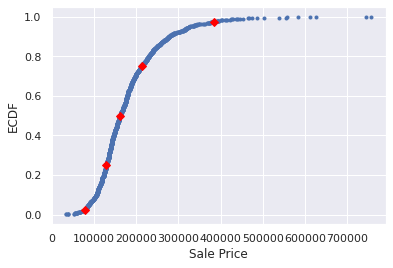

In [40]:
percentiles = np.array([2.5, 25, 50, 75, 97.5])
ptiles = np.percentile(df['SalePrice'], percentiles)
display(ptiles)

x, y = ecdf(df['SalePrice'])
plt.plot(x, y, marker='.', linestyle='none')
plt.plot(ptiles, percentiles/100, marker='D', color='red', linestyle='none')
plt.xlabel('Sale Price')
plt.ylabel('ECDF')

plt.show()

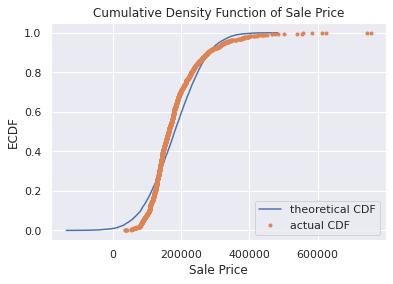

In [41]:
mu = df['SalePrice'].mean()
sigma = df['SalePrice'].std()
samples = np.random.normal(mu, sigma, size=10000)

theoretical_x, theoretical_y = ecdf(samples)
x, y = ecdf(df['SalePrice'])

plt.plot(theoretical_x, theoretical_y, label='theoretical CDF')
plt.plot(x, y, marker='.', linestyle='none', label='actual CDF')
plt.xlabel('Sale Price')
plt.ylabel('ECDF')
plt.title('Cumulative Density Function of Sale Price')
plt.legend(loc='lower right')
plt.show()

Slope is 67.0875522887501
Intercept is -23026.892983277085


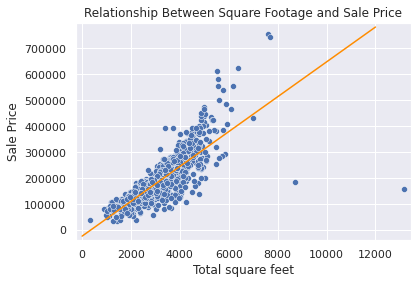

In [42]:
sns.set()

sns.scatterplot(x='TotalSF', y='SalePrice', data=df)
plt.margins(0.02)
plt.xlabel('Total square feet')
plt.ylabel('Sale Price')
plt.title('Relationship Between Square Footage and Sale Price')

a, b = np.polyfit(df['TotalSF'], df['SalePrice'], 1)
print(f"Slope is {a}")
print(f"Intercept is {b}")

x = np.array([0, 12000])
y = a * x + b

plt.plot(x, y, color='darkorange')

plt.show()

I find myself wondering how much those outliers are affecting the line of best fit, and questioning my decision to leave them in.

Slope is 45435.802593099426
Intercept is -96206.0795147603


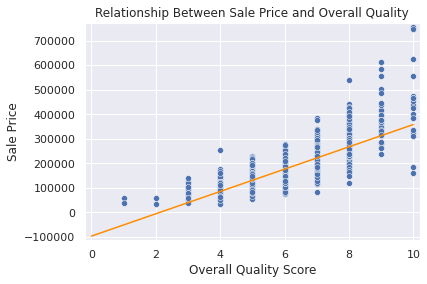

In [43]:
sns.scatterplot(x='OverallQual', y='SalePrice', data=df)
plt.margins(0.02)
plt.xlabel('Overall Quality Score')
plt.ylabel('Sale Price')
plt.title('Relationship Between Sale Price and Overall Quality')

a, b = np.polyfit(df['OverallQual'], df['SalePrice'], 1)
print(f"Slope is {a}")
print(f"Intercept is {b}")

x = np.array([0, 10])
y = a * x + b

plt.plot(x, y, color='darkorange')

plt.show()

In [44]:
df[['SalePrice', 'TotalSF', 'LotArea', 'BedroomAbvGr', 'YearBuilt', 'OverallCond', 'OverallQual']].corr(method='pearson')

,SalePrice,TotalSF,LotArea,BedroomAbvGr,YearBuilt,OverallCond,OverallQual
SalePrice,1.000000,0.809561,0.263843,0.168213,0.522897,-0.077856,0.790982
TotalSF,0.809561,1.000000,0.303583,0.318015,0.404367,-0.157065,0.698060
LotArea,0.263843,0.303583,1.000000,0.119690,0.014228,-0.005636,0.105806
BedroomAbvGr,0.168213,0.318015,0.119690,1.000000,-0.070651,0.012980,0.101676
YearBuilt,0.522897,0.404367,0.014228,-0.070651,1.000000,-0.375983,0.572323
OverallCond,-0.077856,-0.157065,-0.005636,0.012980,-0.375983,1.000000,-0.091932
OverallQual,0.790982,0.698060,0.105806,0.101676,0.572323,-0.091932,1.000000


"TotalSF" and "OverallQual" seem to be having the greatest effects on sale price, but let's throw all of these into a regression to see what happens.

Also, we'll check for multicollinearity.

In [45]:
X_data = df[['TotalSF', 'LotArea', 'BedroomAbvGr', 'YearBuilt', 'OverallCond', 'OverallQual']]
display(X_data.corr())

,TotalSF,LotArea,BedroomAbvGr,YearBuilt,OverallCond,OverallQual
TotalSF,1.000000,0.303583,0.318015,0.404367,-0.157065,0.698060
LotArea,0.303583,1.000000,0.119690,0.014228,-0.005636,0.105806
BedroomAbvGr,0.318015,0.119690,1.000000,-0.070651,0.012980,0.101676
YearBuilt,0.404367,0.014228,-0.070651,1.000000,-0.375983,0.572323
OverallCond,-0.157065,-0.005636,0.012980,-0.375983,1.000000,-0.091932
OverallQual,0.698060,0.105806,0.101676,0.572323,-0.091932,1.000000


In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
reg.fit(X_data, df['SalePrice'])
y_pred = reg.predict(X_data)
r2 = reg.score(X_data, df['SalePrice'])
rmse = np.sqrt(mean_squared_error(df['SalePrice'], y_pred))
print(f"R^2 value is: {r2} and root mean squared error is {rmse}")
print(f"Intercept: {reg.intercept_}")
print(f"Coefficients: 'TotalSF', 'LotArea', 'BedroomAbvGr', 'YearBuilt', 'OverallCond', 'OverallQual'\n{reg.coef_}")

R^2 value is: 0.7741869618950294 and root mean squared error is 37737.97942581816
Intercept: -849830.4407847369
Coefficients: 'TotalSF', 'LotArea', 'BedroomAbvGr', 'YearBuilt', 'OverallCond', 'OverallQual'
[ 4.10447801e+01  6.08195860e-01 -2.59615796e+03  3.77265302e+02
  6.30222053e+03  2.10174053e+04]


In [47]:
import statsmodels.api as sm

y = df['SalePrice']
X = X_data
X = sm.add_constant(X)
linear = sm.OLS(endog=y, exog=X)
results = linear.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     830.3
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        17:06:48   Log-Likelihood:                -17458.
No. Observations:                1460   AIC:                         3.493e+04
Df Residuals:                    1453   BIC:                         3.497e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -8.498e+05   8.69e+04     -9.776      0.000   -1.02e+06   -6.79e+05
TotalSF         41.0448      1.636     25.095      0.000      37.836      44.253
LotArea          0.6082      0.106      5.755      0.000       0.401       0.815
BedroomAbvGr -2596.1580   1320.770     -1.966      0.050   -5186.977      -5.339
YearBuilt      377.2653     44.187      8.538      0.000     290.588     463.943
OverallCond   6302.2205    983.139      6.410      0.000    4373.697    8230.744
OverallQual   2.102e+04   1153.436     18.222      0.000    1.88e+04    2.33e+04
==============================================================================
Omnibus:                      706.304   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           126807.781
Skew:                          -1.137   Prob(JB):                         0.00
Kurtosis:                      48.600   Cond. No.                     1.30e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

An R-squared of 0.77 isn't great, but it isn't bad. It looks like the number of bedrooms isn't particularly significant. 